ABIDA Youssef (p2024398)
VADUREL Benjamin (2000154)

# Projet GNN - Classification de noeuds

# Imports

In [1]:
import networkx as nx
import torch
from torch_geometric.utils import from_networkx

from GAT_Forward1 import GAT_Forward1
from GAT_Forward2 import GAT_Forward2
from GAT_Forward3 import GAT_Forward3
from GAT_Forward4 import GAT_Forward4
from GAT_MultiHead1 import GAT_MultiHead1
from GAT_Multihead2 import GAT_Multihead2

from GATBayesianOptimizer import GATBayesianOptimizer
from MultiHeadGATBayesianOptimizer import MultiHeadGATBayesianOptimizer

from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore


c:\Users\Josephir\anaconda3\envs\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
G = nx.read_graphml('../data/airportsAndCoordAndPop.graphml.xml')
G.nodes(data=True)

NodeDataView({'0': {'lon': -145.50972222222222, 'lat': -17.35388888888889, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Anaa'}, '1': {'lon': -140.95, 'lat': -18.066666666666666, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Hao Island'}, '2': {'lon': -149.6, 'lat': -17.55, 'population': 26357, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Papeete'}, '3': {'lon': -135.0, 'lat': -23.033333333333335, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Gambier Island'}, '4': {'lon': -143.65725, 'lat': -16.584888888888887, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Makemo'}, '5': {'lon': 174.79166666666666, 'lat': -37.00805555555556, 'population': 417910, 'country': 'NEW_ZEALAND', 'city_name': 'Auckland'}, '6': {'lon': -139.03333333333333, 'lat': -9.8, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Atuona'}, '7': {'lon': -151.75, 'lat': -16.45, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 

# Data description
 - lon : float
 - lat : float
 - population : int
 - country : string (exemple : 'FRENCH_POLYNESIA')
 - city_name : string (exemple : 'Anaa')

In [4]:
def encode_city_name(graph):
    city_names = nx.get_node_attributes(graph, 'city_name')
    print(city_names)

    encoder = LabelEncoder()
    print(city_names.values())
    city_names_encoder = encoder.fit(list(city_names.values()))

    for node in graph.nodes():
        graph.nodes[node]['city_name'] = city_names_encoder.transform([graph.nodes[node]['city_name']])[0]

    graph.nodes(data=True)

In [56]:
# nx.draw(graph, with_labels=False, node_size=8)

In [ ]:
def remove_isolated_nodes(min_degree=1):
    graph = nx.read_graphml('../data/airportsAndCoordAndPop.graphml.xml')
    nodes_to_remove = [node for node in graph.nodes if graph.degree(node) < min_degree]
    graph.remove_nodes_from(nodes_to_remove)
    return graph

# new_graph = remove_isolated_nodes(min_degree=3)

# nx.draw(new_graph, with_labels=False, node_size=8) 


In [5]:
# encode_city_name(new_graph)
encode_city_name(G)

{'0': 'Anaa', '1': 'Hao Island', '2': 'Papeete', '3': 'Gambier Island', '4': 'Makemo', '5': 'Auckland', '6': 'Atuona', '7': 'Bora Bora', '8': 'Honolulu', '9': 'Huahine', '10': 'Easter Island', '11': 'Kaukura Atoll', '12': 'Los Angeles', '13': 'Moorea', '14': 'Nuku Hiva', '15': 'Noumea', '16': 'Osaka', '17': 'Mataiva', '18': 'Rarotonga', '19': 'Raiatea Island', '20': 'Rangiroa Island', '21': 'Rurutu', '22': 'Tikehau Atoll', '23': 'Takaroa', '24': 'Tubuai', '25': 'Tokyo', '26': 'Wallis Island', '27': 'Manihi', '28': 'Apia', '29': 'Blenheim', '30': 'Brisbane', '31': 'Buenos Aires', '32': 'Christchurch', '33': 'Cairns', '34': 'Denpasar Bali', '35': 'Gisborne', '36': 'Hong Kong', '37': 'Hamilton', '38': 'Niue', '39': 'Kaitaia', '40': 'Kerikeri', '41': 'Kuala Lumpur', '42': 'Melbourne', '43': 'Nadi', '44': 'Nagoya', '45': 'Norfolk Island', '46': 'Napier-Hastings', '47': 'New Plymouth', '48': 'Nelson', '49': 'Perth', '50': 'Palmerston North', '51': 'Rotorua', '52': 'Seoul', '53': 'Singapore',

In [6]:
def convert_graph_to_data(graph):
    data = from_networkx(graph, group_node_attrs=["lon", "lat", "city_name"])
    
    return data

def print_data_info(data):
    print(data)
    print(data.num_nodes)
    print(data.num_edges)
    print(data.num_node_features)

In [7]:
# data = convert_graph_to_data(new_graph)
data = convert_graph_to_data(G)

print_data_info(data)

Data(edge_index=[2, 27094], population=[3363], country=[3363], x=[3363, 3])
3363
27094
3


In [8]:
data_copy = data.clone()
print(data_copy)

Data(edge_index=[2, 27094], population=[3363], country=[3363], x=[3363, 3])


# Exploratory data analysis

In [9]:
def create_df(graph):
    nodes_data = []
    for node, feature in graph.nodes(data=True):
        nodes_data.append(feature)

    df = pd.DataFrame(nodes_data)
    return df

In [10]:
# df = create_df(new_graph)
df = create_df(G)

## Visualisation

In [11]:
def visualize_distribution(data_frame):
    for column in data_frame.columns:
        if data_frame[column].dtype in [np.float64, np.int64]:
            plt.figure(figsize=(10, 6))
            sns.histplot(data_frame[column], kde=True)
            plt.title(f'Distribution of {column}')
            plt.show()

            counts, bin_edges = np.histogram(data_frame[column], bins='auto')
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

            print(f"Values for {column}:")
            for bin_center, count in zip(bin_centers, counts):
                print(f"Bin center: {bin_center}, Count: {count}")

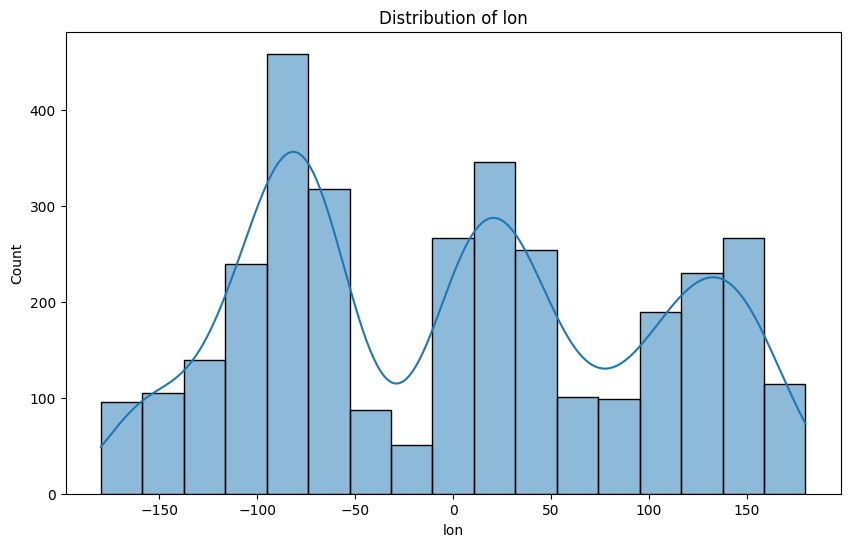

Values for lon:
Bin center: -169.28529411764708, Count: 96
Bin center: -148.12254901960785, Count: 105
Bin center: -126.95980392156864, Count: 139
Bin center: -105.79705882352943, Count: 240
Bin center: -84.63431372549022, Count: 459
Bin center: -63.471568627451, Count: 318
Bin center: -42.30882352941178, Count: 87
Bin center: -21.146078431372572, Count: 51
Bin center: 0.016666666666637298, Count: 267
Bin center: 21.179411764705847, Count: 346
Bin center: 42.34215686274506, Count: 254
Bin center: 63.50490196078428, Count: 101
Bin center: 84.66764705882349, Count: 99
Bin center: 105.8303921568627, Count: 190
Bin center: 126.99313725490191, Count: 230
Bin center: 148.15588235294112, Count: 267
Bin center: 169.3186274509804, Count: 114


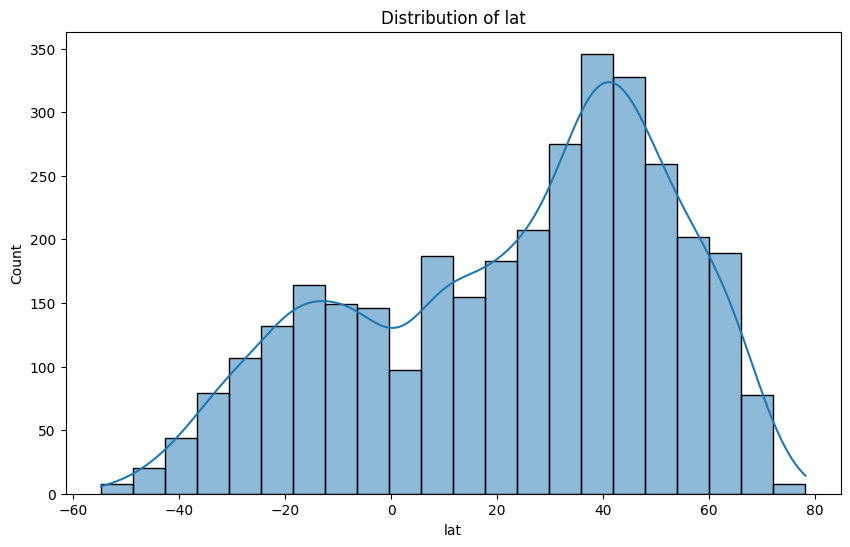

Values for lat:
Bin center: -51.792531565656574, Count: 8
Bin center: -45.74426136363637, Count: 20
Bin center: -39.69599116161616, Count: 44
Bin center: -33.64772095959596, Count: 79
Bin center: -27.59945075757576, Count: 107
Bin center: -21.55118055555556, Count: 132
Bin center: -15.50291035353536, Count: 164
Bin center: -9.454640151515157, Count: 149
Bin center: -3.4063699494949518, Count: 146
Bin center: 2.64190025252525, Count: 97
Bin center: 8.690170454545449, Count: 187
Bin center: 14.73844065656565, Count: 155
Bin center: 20.786710858585856, Count: 183
Bin center: 26.834981060606054, Count: 207
Bin center: 32.88325126262625, Count: 275
Bin center: 38.93152146464646, Count: 346
Bin center: 44.979791666666664, Count: 328
Bin center: 51.02806186868687, Count: 259
Bin center: 57.07633207070707, Count: 202
Bin center: 63.12460227272726, Count: 189
Bin center: 69.17287247474746, Count: 78
Bin center: 75.22114267676767, Count: 8


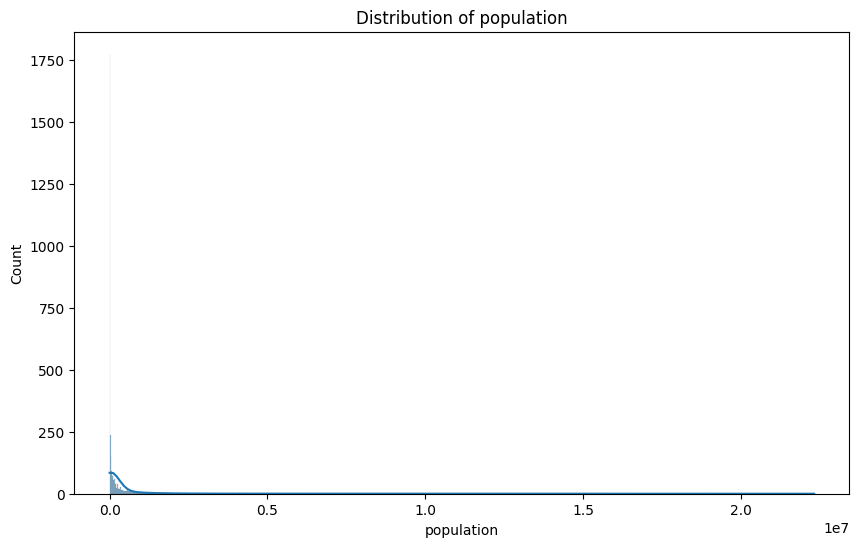

Values for population:
Bin center: 10339.10304347826, Count: 1776
Bin center: 29743.309130434784, Count: 237
Bin center: 49147.51521739131, Count: 151
Bin center: 68551.72130434783, Count: 92
Bin center: 87955.92739130434, Count: 71
Bin center: 107360.13347826086, Count: 81
Bin center: 126764.3395652174, Count: 56
Bin center: 146168.54565217393, Count: 59
Bin center: 165572.7517391304, Count: 43
Bin center: 184976.95782608696, Count: 38
Bin center: 204381.16391304345, Count: 45
Bin center: 223785.37, Count: 24
Bin center: 243189.57608695654, Count: 41
Bin center: 262593.78217391303, Count: 22
Bin center: 281997.9882608695, Count: 21
Bin center: 301402.19434782607, Count: 25
Bin center: 320806.4004347826, Count: 18
Bin center: 340210.60652173916, Count: 27
Bin center: 359614.81260869565, Count: 13
Bin center: 379019.01869565214, Count: 16
Bin center: 398423.2247826087, Count: 19
Bin center: 417827.4308695652, Count: 17
Bin center: 437231.6369565217, Count: 12
Bin center: 456635.84304347

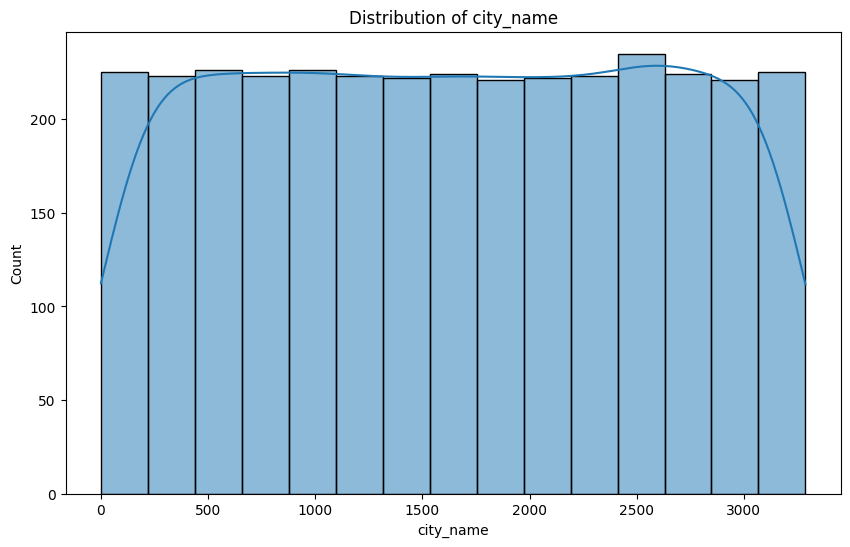

Values for city_name:
Bin center: 109.56666666666666, Count: 225
Bin center: 328.7, Count: 223
Bin center: 547.8333333333333, Count: 226
Bin center: 766.9666666666667, Count: 223
Bin center: 986.0999999999999, Count: 226
Bin center: 1205.2333333333331, Count: 223
Bin center: 1424.3666666666668, Count: 222
Bin center: 1643.5, Count: 224
Bin center: 1862.6333333333332, Count: 221
Bin center: 2081.7666666666664, Count: 222
Bin center: 2300.8999999999996, Count: 223
Bin center: 2520.0333333333333, Count: 235
Bin center: 2739.1666666666665, Count: 224
Bin center: 2958.3, Count: 221
Bin center: 3177.4333333333334, Count: 225


In [12]:
visualize_distribution(df)

> La distribution des valeurs pour la population est très inégale, avec une grande majorité des valeurs concentrées sur les bins inférieurs.

# Dirty data?

In [13]:
def calc_z_scores(data_frame):
    z_scores = np.abs(zscore(data_frame[['lon', 'lat', 'population', 'city_name']]))
    print(f"Z-scores: {z_scores}")
    outliers = np.where(z_scores > 3)
    print(f"Outliers detected at indices: {outliers}")

    # Afficher les valeurs des outliers
    for column in data_frame.columns:
        outlier_indices = outliers[0][outliers[1] == data_frame.columns.get_loc(column)]
        outlier_values = data_frame.loc[outlier_indices, column]
        print(f"Outliers in {column}: {outlier_values.values}")

    for column in data_frame.columns:
        if data_frame[column].dtype in [np.float64, np.int64]:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=data_frame[column])
            plt.title(f'Boxplot of {column}')
            plt.show()

    return z_scores, outliers


Z-scores:            lon       lat  population  city_name
0     1.515711  1.376629    0.259939   1.627658
1     1.468440  1.400931    0.259939   0.604134
2     1.558115  1.383315    0.246979   0.592083
3     1.406757  1.570270    0.259939   0.763138
4     1.496506  1.350409    0.259939   0.063473
...        ...       ...         ...        ...
3358  0.728933  1.296453    0.259939   0.713179
3359  1.514863  0.992925    0.259939   0.974793
3360  1.180797  1.081532    0.259939   1.636667
3361  1.512582  0.994062    0.259939   1.676681
3362  1.519321  0.989516    0.259939   1.596653

[3363 rows x 4 columns]
Outliers detected at indices: (array([  25,   36,   42,   52,   53,   54,   56,  110,  116,  143,  149,
        156,  199,  213,  214,  215,  218,  224,  227,  248,  249,  253,
        256,  259,  273,  286,  343,  353,  373,  420,  421,  422,  424,
        425,  429,  430,  431,  432,  440,  443,  448,  450,  453,  464,
        468,  472,  479,  484,  658,  742,  857, 1005, 1140, 1732,

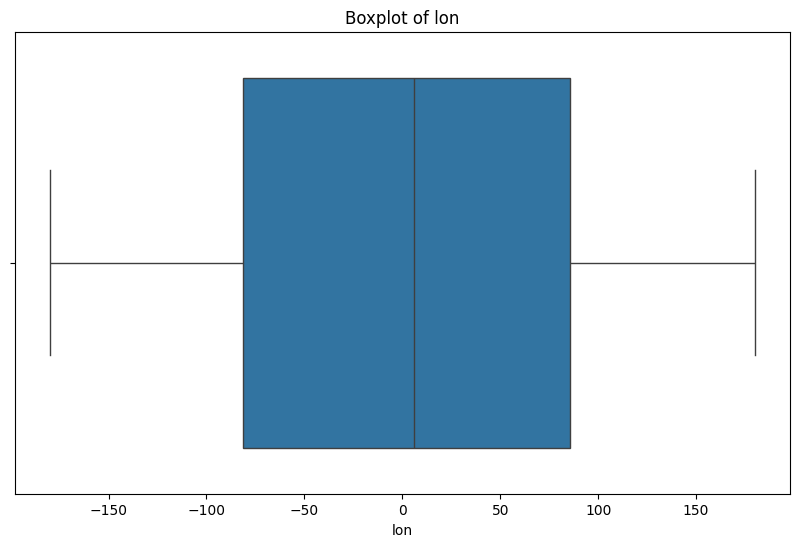

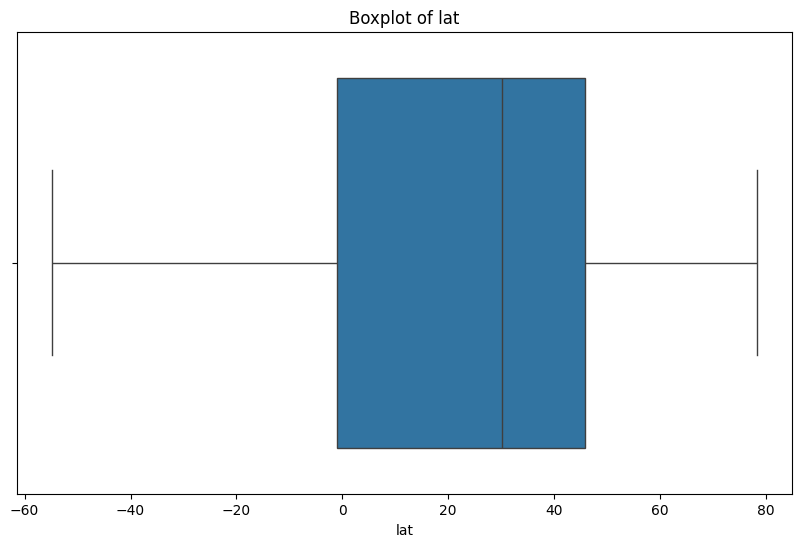

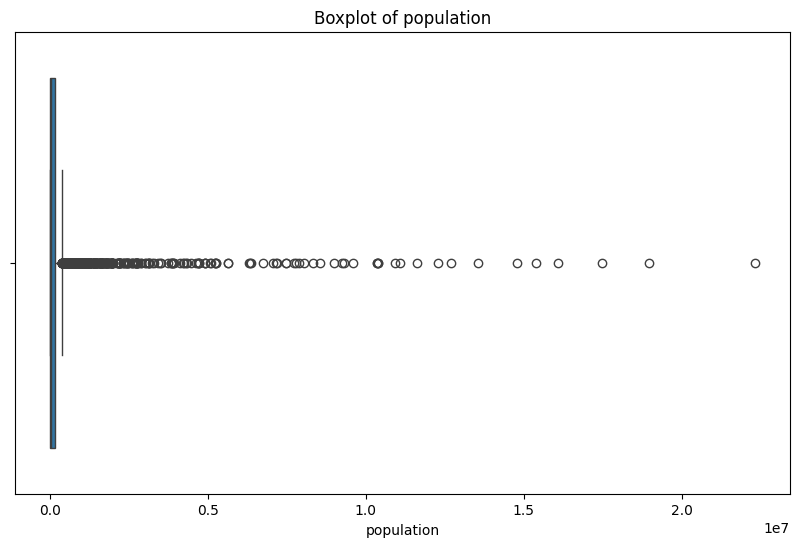

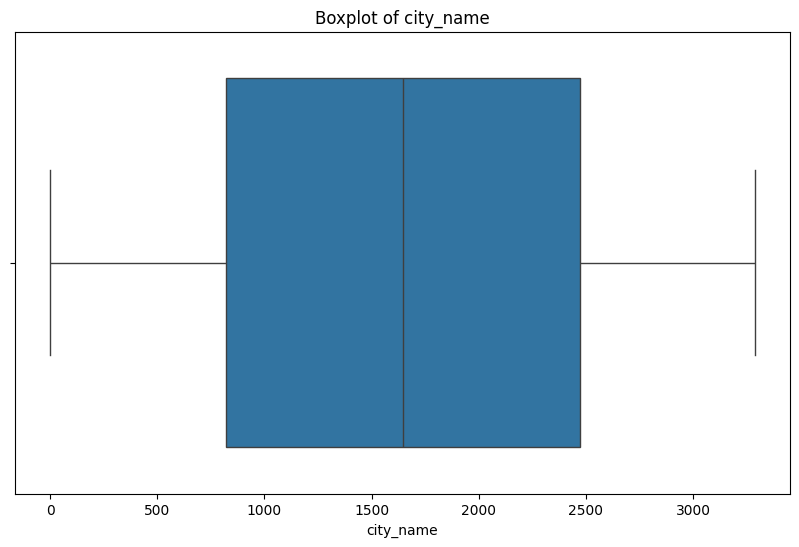

In [14]:
z_scores, outliers = calc_z_scores(df)

> Les outliers détectés dans la colonne population peuvent être des anomalies ou des données correctes mais extrêmes. Les données de la population seront donc retirées pour netttoyer les données.

In [ ]:
df = df.drop(columns=['population'])
data_copy.population = None 

print(df.shape)
print(data_copy)

In [ ]:
print(f"data_copy.x shape: {data_copy.x.shape}, data_copy.edge_index shape: {data_copy.edge_index.shape}")
print(f"Min index in edge_index: {data_copy.edge_index.min()}, Max index: {data_copy.edge_index.max()}, Number of nodes: {data_copy.x.shape[0]}")

# Nettoyer et centrer réduire les données

In [ ]:
# Suppression des outliers
mask_cleaned = (np.abs(z_scores) < 3).all(axis=1)
df_cleaned = df[mask_cleaned]

new_indices = np.where(mask_cleaned)[0]
node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(new_indices)}

updated_edge_index = data_copy.edge_index.clone()
for i in range(updated_edge_index.shape[1]):
    u, v = updated_edge_index[:, i].numpy()
    if u in node_mapping and v in node_mapping:
        updated_edge_index[0, i] = node_mapping[u]
        updated_edge_index[1, i] = node_mapping[v]
    else:
        updated_edge_index[:, i] = -1

valid_edges = (updated_edge_index[0, :] != -1)
updated_edge_index = updated_edge_index[:, valid_edges]

# Mise à jour des données pour le modèle
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[['lon', 'lat', 'city_name']]), columns=['lon', 'lat', 'city_name'])

# data_copy.x = torch.tensor(df_scaled.values, dtype=torch.float)
data_copy.x = torch.tensor(df_cleaned[['lon', 'lat', 'city_name']].values, dtype=torch.float)
data_copy.edge_index = updated_edge_index
data_copy.country = df_cleaned['country'].to_list()

# Vérification
print(f"data_copy.x shape: {data_copy.x.shape}, data_copy.edge_index shape: {data_copy.edge_index.shape}")
print(f"Min index in edge_index: {data_copy.edge_index.min()}, Max index: {data_copy.edge_index.max()}, Number of nodes: {data_copy.x.shape[0]}")



# Preprocessing

In [15]:

encoder = LabelEncoder()

country_encoder = encoder.fit(data_copy.country)
data_copy.country = encoder.transform(data_copy.country)

target_tensor = torch.tensor(data_copy.country, dtype=torch.long)
data_copy.y = target_tensor
data_copy.num_classes = len(set(data_copy.country))


train_ratio = 0.8

mask = torch.rand(data_copy.num_nodes) < train_ratio
data_copy.train_mask = mask
data_copy.test_mask = ~mask

temp = torch.zeros((data_copy.num_nodes, data_copy.num_node_features), dtype=torch.float)
temp[data_copy.train_mask] = data_copy.x[data_copy.train_mask]
data_copy.x = temp

data_copy = data_copy.to(device)

print(f"train_mask shape: {data_copy.train_mask.shape}, test_mask shape: {data_copy.test_mask.shape}")
print(f"x shape: {data_copy.x.shape}, num_nodes: {data_copy.num_nodes}")
print(f"y min: {data_copy.y.min()}, y max: {data_copy.y.max()}, num_classes: {data_copy.num_classes}")
print(f"data_copy.x dtype: {data_copy.x.dtype}")
print(f"data_copy.y dtype: {data_copy.y.dtype}")


# print(data_copy.num_classes)
# print(data_copy)

train_mask shape: torch.Size([3363]), test_mask shape: torch.Size([3363])
x shape: torch.Size([3363, 3]), num_nodes: 3363
y min: 0, y max: 211, num_classes: 212
data_copy.x dtype: torch.float32
data_copy.y dtype: torch.int64


# Test initial

In [16]:
test_model1 = GAT_Forward1(data_copy.x.shape[1], 300, data_copy.num_classes, dropout=0.3)
test_model1 = test_model1.to(device)
test_model1.fit(data_copy, 1000)
print(test_model1.test_model(data_copy))

(0.18409425625920472, np.float64(0.039426594510824614), np.float64(108.99218331405268))


In [ ]:
test_model2 = GAT_Forward2(data_copy.x.shape[1], 300, data_copy.num_classes, dropout=0.3)
test_model2 = test_model2.to(device)
test_model2.fit(data_copy, 1000)
print(test_model2.test_model(data_copy))

In [ ]:
test_model3 = GAT_Forward3(data_copy.x.shape[1], 300, data_copy.num_classes, dropout=0.3)
test_model3 = test_model3.to(device)
test_model3.fit(data_copy, 1000)
print(test_model3.test_model(data_copy))

In [ ]:
test_model4 = GAT_Forward4(data_copy.x.shape[1], 300, data_copy.num_classes, dropout=0.3)
test_model4 = test_model4.to(device)
test_model4.fit(data_copy, 1000)
print(test_model4.test_model(data_copy))

> On peut voir que en moyenne nos scores ne depassent pas une accuracy de 18% sur l'ensemble des modeles GAT a un seul head.

# Bayesian Optimization

In [17]:
def run_bayesian_optim(data, nb_trials, train_nbr_epochs, model_class):
    bayesian_optimizer = GATBayesianOptimizer(data, nb_trials, train_nbr_epochs)
    study = bayesian_optimizer.create_study(model_class=model_class)
    best_accuracy, best_precision, best_rmse, best_hyperparameters = bayesian_optimizer.get_best_study(study)

    print("\n")
    print(f"Best accuracy: {best_accuracy}")
    print(f"Best precision: {best_precision}")
    print(f"Best RMSE: {best_rmse}")
    print(f"Best hyperparameters: {best_hyperparameters}")

    return best_accuracy, best_precision, best_rmse, best_hyperparameters

In [18]:
def update_saved_model(save_path, best_acc, best_prec, best_rmse, best_hyperparam, best_model, data):
    try:
        checkpoint = torch.load(save_path)
        saved_best_acc = checkpoint['best_accuracy']
        saved_best_prec = checkpoint['best_precision']
        saved_best_rmse = checkpoint['best_rmse']
    except FileNotFoundError:
        saved_best_acc = -float('inf')
        saved_best_prec = -float('inf')
        saved_best_rmse = float('inf')

    if (best_acc > saved_best_acc) and (best_prec > saved_best_prec) and (best_rmse < saved_best_rmse):
        best_model.save_model(
            save_path,
            best_accuracy=best_acc,
            best_precision=best_prec,
            best_rmse=best_rmse,
            best_hyperparameters=best_hyperparam,
            input_dim=data.x.shape[1],
            output_dim=data.num_classes
        )
        print(f"Model saved with improved results: Acc={best_acc}, Prec={best_prec}, RMSE={best_rmse}")
    else:
        print(f"Model not saved. Current results are not better than saved results: Acc={saved_best_acc}, Prec={saved_best_prec}, RMSE={saved_best_rmse}")


In [ ]:
best_acc1, best_prec1, best_rmse1, best_hyper1 = run_bayesian_optim(data_copy, 15, 7000, GAT_Forward1)

In [ ]:
best_acc2, best_prec2, best_rmse2, best_hyper2 = run_bayesian_optim(data_copy, 4, 7000, GAT_Forward2)

In [ ]:
best_acc3, best_prec3, best_rmse3, best_hyper3 = run_bayesian_optim(data_copy, 4, 7000, GAT_Forward3)

In [ ]:
best_acc4, best_prec4, best_rmse4, best_hyper4 = run_bayesian_optim(data_copy, 4, 7000, GAT_Forward4)

# Saving models

In [20]:
def train_and_save_model(model_class, data, save_path, train_nbr_epochs, best_acc, best_prec, best_rmse, best_hyperparam):
    best_model = model_class(
        data.x.shape[1],
        best_hyperparam['nb_neurons'],
        data.num_classes,
        dropout=best_hyperparam['dropout']
    ).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    best_model.fit(data, epochs=train_nbr_epochs, lr=best_hyperparam['lr'], wd=best_hyperparam['weight_decay'])

    update_saved_model(save_path, best_acc, best_prec, best_rmse, best_hyperparam, best_model, data)


# Load models

In [21]:
b_model1, hyper1, checkpoint1 = GAT_Forward1.load_model('../runs/avant_analyse/models/GAT_Forward1.pth')
b_model1 = b_model1.to(device)
accuracy, precision, rmse = b_model1.test_model(data_copy)
print(f"Accuracy: {accuracy}, Precision: {precision}, RMSE: {rmse}")

Accuracy: 0.4477172312223859, Precision: 0.48144659287764097, RMSE: 73.65871825295788


c:\Users\Josephir\Documents\Josephir\UCBL\M1+\BioInspiredMachineLearning\TP-Cazabet\bioml-gnn-classification\GAT\GAT_Forward1.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

# Testing hyperparams on the other models

In [32]:
def multi_runs(model_class, data, nb_runs, device, save_path, dropout=0.0015058484884345191, lr=0.0010312531082429088, wd=2.7069760917328855e-05, nb_neurons=305):
    all_runs = {}

    hyper = {
        'lr': lr,
        'weight_decay': wd,
        'nb_neurons': nb_neurons,
        'dropout': dropout
    }

    for run in range(nb_runs):
        print(f"Run {run}")
        current_model = model_class(data.x.shape[1], nb_neurons, data.num_classes, dropout=dropout)
        current_model = current_model.to(device)
        current_model.fit(data, 7000, lr=lr, wd=wd)
        accuracy, precision, rmse = current_model.test_model(data)

        update_saved_model(save_path, accuracy, precision, rmse, hyper, current_model, data)
        
        all_runs[run] = (accuracy, precision, rmse)
    
    print("\n")
    for run in all_runs:
        print(f"Run {run}: Accuracy: {all_runs[run][0]}, Precision: {all_runs[run][1]}, RMSE: {all_runs[run][2]}")

    avg_accuracy = sum([all_runs[run][0] for run in all_runs]) / nb_runs
    avg_precision = sum([all_runs[run][1] for run in all_runs]) / nb_runs
    avg_rmse = sum([all_runs[run][2] for run in all_runs]) / nb_runs

    return avg_accuracy, avg_precision, avg_rmse

In [ ]:
gat_f1_avg_acc, gat_f1_avg_prec, gat_f1_avg_rmse = multi_runs(GAT_Forward1, data_copy, 10, device, '../runs/avant_analyse/models/GAT_Forward1.pth')
print(f"\n Average Accuracy: {gat_f1_avg_acc}, Average Precision: {gat_f1_avg_prec}, Average RMSE: {gat_f1_avg_rmse}")

In [ ]:
gat_f2_avg_acc, gat_f2_avg_prec, gat_f2_avg_rmse = multi_runs(GAT_Forward2, data_copy, 4, device, '../runs/avant_analyse/models/GAT_Forward2.pth')

In [ ]:
gat_f3_avg_acc, gat_f3_avg_prec, gat_f3_avg_rmse = multi_runs(GAT_Forward3, data_copy, 4, device, '../runs/avant_analyse/models/GAT_Forward3.pth')

In [ ]:
gat_f4_avg_acc, gat_f4_avg_prec, gat_f4_avg_rmse = multi_runs(GAT_Forward4, data_copy, 4, device, '../runs/avant_analyse/models/GAT_Forward4.pth')

# GAT MultiHead Bayesian Optimization

In [26]:
def run_bayesian_optim_multi(data, nb_trials, train_nbr_epochs):
    bayesian_optimizer = MultiHeadGATBayesianOptimizer(data, nb_trials, train_nbr_epochs)

    multi1_study = bayesian_optimizer.create_study(model_class=GAT_MultiHead1)
    bayesian_optimizer.get_best_study(multi1_study)
    print("GAT_MultiHead1 1 done")
    print("\n")

    multi2_study = bayesian_optimizer.create_study(model_class=GAT_Multihead2)
    bayesian_optimizer.get_best_study(multi2_study)
    print("GAT_MultiHead1 2 done")
    print("\n")

In [ ]:
run_bayesian_optim_multi(data_copy, 12, 7000)

Best Accuracy: `0.7219518248175235`

> Best hyperparameters: {'lr': 0.004302999952375387, 'weight_decay': 0.0004080276447126268, 'nb_neurons': 108, 'nb_heads': 7, 'dropout': 0.03530852955668911}



In [33]:
multi1 = GAT_MultiHead1(data_copy.x.shape[1], 108, data_copy.num_classes, heads=7, dropout=0.03530852955668911)
multi1 = multi1.to(device)
multi1.fit(data_copy, 7000, lr=0.004302999952375387, wd=0.0004080276447126268)
mult1_acc, mult1_prec, mult1_rmse = multi1.test_model(data_copy)
print(f"Accuracy: {mult1_acc}, Precision: {mult1_prec}, RMSE: {mult1_rmse}")

Accuracy: 0.0014727540500736377, Precision: 2.7893069130182532e-06, RMSE: 100.27311011764662


In [ ]:
multi2 = GAT_Multihead2(data_copy.x.shape[1], 108, data_copy.num_classes, heads=7, dropout=0.03530852955668911)
multi2 = multi2.to(device)
multi2.fit(data_copy, 7000, lr=0.004302999952375387, wd=0.0004080276447126268)
mult2_acc, mult2_prec, mult2_rmse = multi2.test_model(data_copy)
print(f"Accuracy: {mult2_acc}, Precision: {mult2_prec}, RMSE: {mult2_rmse}")


# Testing save and load model

In [34]:
b_model1, hyper1, checkpoint = GAT_Forward1.load_model('../runs/avant_analyse/models/GAT_Forward1.pth')
b_model1 = b_model1.to(device)
print(b_model1.test_model(data_copy))
accuracy, precision, rmse = b_model1.test_model(data_copy)
print(f"Accuracy: {accuracy}, Precision: {precision}, RMSE: {rmse}")

(0.4477172312223859, np.float64(0.48144659287764097), np.float64(73.65871825295788))
Accuracy: 0.4477172312223859, Precision: 0.48144659287764097, RMSE: 73.65871825295788


c:\Users\Josephir\Documents\Josephir\UCBL\M1+\BioInspiredMachineLearning\TP-Cazabet\bioml-gnn-classification\GAT\GAT_Forward1.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

In [35]:
new_model = GAT_Forward1(data_copy.x.shape[1], 2, data_copy.num_classes, dropout=0.5)
new_model = new_model.to(device)
new_model.fit(data_copy, 100)
new_model.test_model(data_copy)

print(new_model.test_model(data_copy))

new_model.save_model("../runs/avant_analyse/models/GAT_Forward1_test.pth", 0.5, 0.5, 0.5, {'lr': 0.001, 'weight_decay': 0.0001, 'nb_neurons': 2, 'dropout': 0.5}, data_copy.x.shape[1], data_copy.num_classes)

(0.187039764359352, np.float64(0.03498387345160192), np.float64(114.24687116046468))


In [36]:
test, _, _  = GAT_Forward1.load_model("../runs/avant_analyse/models/GAT_Forward1_test.pth")
test = test.to(device)
print(test.test_model(data_copy))

(0.187039764359352, np.float64(0.03498387345160192), np.float64(114.24687116046468))


c:\Users\Josephir\Documents\Josephir\UCBL\M1+\BioInspiredMachineLearning\TP-Cazabet\bioml-gnn-classification\GAT\GAT_Forward1.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

# Ablation study

Avec 2 couches de GATConv

In [ ]:
# ablation_study1_acc, ablation_study1_prec, ablation_study1_rmse = multi_runs(GAT_Forward1, data_copy, 1, device, '../runs/ablation_study/models/GAT_Forward1_1couche.pth') 
# Run 0: Accuracy: 0.6366366366366366, Precision: 0.6151221430854393, RMSE: 61.37109589547356

Avec 1 couche de GATConv

In [ ]:
# ablation_study2_acc, ablation_study2_prec, ablation_study2_rmse = multi_runs(GAT_Forward1, data_copy, 1, device, '../runs/ablation_study/models/GAT_Forward1_2couches.pth')
# Run 0: Accuracy: 0.43950995405819293, Precision: 0.336961771317817, RMSE: 70.95198212332181


Avec aucun ELU dans la fonction d'activation

In [ ]:
# abl_study3_acc, abl_study3_prec, abl_study3_rmse = multi_runs(GAT_Forward1, data_copy, 1, device, '../runs/ablation_study/models/GAT_Forward1_0elu.pth')
# Run 0: Accuracy: 0.2684766214177979, Precision: 0.10214880047070518, RMSE: 97.627157287922

Sans softmax dans la fonction d'activation

In [ ]:
# abl_study4_acc, abl_study4_prec, abl_study4_rmse = multi_runs(GAT_Forward1, data_copy, 1, device, '../runs/ablation_study/models/GAT_Forward1_sans_softmax.pth')
# Run 0: Accuracy: 0.7419847328244275, Precision: 0.7322232042374817, RMSE: 55.345190182489006

Sans dropout

In [ ]:
# abl_study5_acc, abl_study5_prec, abl_study5_rmse = multi_runs(GAT_Forward1, data_copy, 1, device, '../runs/ablation_study/models/GAT_Forward1_sans_dropout.pth')
# Model saved with improved results: Acc=0.5981308411214953, Prec=0.614413480674709, RMSE=64.12945678402656